In [1]:
import scipy.io as sio
import numpy as np
import os
import pandas as pd

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

## Source Data

Paper [link](https://www.nature.com/articles/s41467-021-24336-w)

Github repo [link](https://github.com/alxdroR/SRNatComm21)


Lab Current Code : https://github.com/alxdroR/zfOcMotor/tree/greg

## Loading main data

In [2]:
base_dir = "/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging"
traces = os.path.join(base_dir, "CaTracesAndFootprints/")
behavior = os.path.join(base_dir, "behavior10to20Hz/")


In [3]:
muf = sio.loadmat(traces + "f1_traces_EPSelect.mat")
muf.keys()

dict_keys(['__header__', '__version__', '__globals__', 'expMetaData', 'filenames', 'fluorescence', 'filtFl', 'frate', 'Por', 'b2', 'f2', 'localCoordinates', 'A', 'twitchFrames', 'twitchTimes', 'MCerror', 'syncOffset', 'cellSelectParam'])

In [4]:
class zfSessionData:
    def __init__(self, fish=[], method='ep'):
        self.base_dir = "/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging"        
        self.traces = os.path.join(self.base_dir, "CaTracesAndFootprints/")
        self.behavior = os.path.join(self.base_dir, "behavior10to20Hz/")
    
        EP = [s for s in os.listdir(self.traces) if "traces_EPSelect" in s] # CaImAN
        IM = [s for s in os.listdir(self.traces) if "traces_IMOpenSelect" in s] # avg intensity
        self.files = EP if method == 'ep' else IM
        self.method = method.lower()
        self.fish_names = [s.split('_')[0] for s in self.files]
        self.fish_names.sort()
        
        self.data = {}     
        for f in fish:
            print(f"Parsing {f} data")
            self.parse_trace(f)

    def get_filename(self, fish):
        if(self.method == 'ep'):
            return(f"{fish}_traces_EPSelect.mat")
        elif(self.method == 'im'):
            return(f"{fish}_traces_IMOpenSelect.mat")
        
    def parse_trace(self, fish):
        filename = self.get_filename(fish)
        data = sio.loadmat(os.path.join(self.traces, filename))
        cellLocs = [file[0] for file in data['localCoordinates']]
        fluor = [file[0] for file in data['fluorescence']]
        num_samples = fluor[0].shape[1] # num_cells x num_samples
        file_data = {
            'fluor' : fluor,
            'cellLocations' : cellLocs,
            'num_samples' : num_samples,
        }
        self.data[fish] = file_data
        return(data)

    def load_behavior(self, fish, idx):
        fname = os.path.join(self.behavior, f"{fish}_{idx}.mat")
        data = sio.loadmat(fname)
        return(data)
    
    def load_trajectory(self, fish, idx):
        # idx belongs to different OG tiff files (RHB vs non RHB?), likely z planes
        fluor = self.data[fish]['fluor'][idx]
        loc = self.data[fish]['cellLocations'][idx]
        # dF/F
        temporal_mean = np.mean(fluor, axis=1).reshape(-1, 1)
        dFF = (fluor - temporal_mean) / temporal_mean

        N, t = dFF.shape
        da = xr.DataArray(dFF, dims=('N', 'T'), coords={'N' : np.arange(1, N+1), 'T' : np.arange(0, t), 
                                                        'X' : (('N',), loc[:,0]), 'Y' : (('N',), loc[:,1])})
        
        return(da)

In [5]:
zf = zfSessionData(['f1'])

Parsing f1 data


In [6]:
zf.data['f1']['cellLocations'][2]

array([[107.97604999, 364.92869762],
       [138.32277128, 502.39136487],
       [136.56898413, 474.74172388],
       [ 88.54069708, 361.15932442],
       [ 87.25638037,  57.33936519],
       [  5.45634071, 133.79771293],
       [ 53.15621192,  47.39353067],
       [395.62413975, 222.82432957],
       [ 80.22708233, 144.62048729],
       [163.92881355, 503.4435264 ],
       [ 72.92984497, 375.61033943],
       [180.58536061, 116.87960927],
       [ 21.68323116, 200.54244648],
       [ 28.9400884 , 283.05210672],
       [152.40205032, 241.95009976],
       [370.92001341, 211.59557526],
       [ 73.62499306, 300.0179954 ],
       [128.4813555 , 228.20469686],
       [105.39954884, 375.51948791],
       [126.09924068, 503.2584571 ],
       [ 48.25119603, 249.51351441],
       [ 75.69647059, 365.64569234],
       [443.29316467, 503.98191224],
       [ 89.11786736, 373.13185466],
       [  7.70346049, 150.70917825],
       [ 12.51850616, 272.2477415 ],
       [140.88535712, 223.683953  ],
 

In [7]:
T = zf.load_trajectory('f1', 5)

T

<xarray.DataArray (N: 217, T: 234)>
array([[ 1.34475294e+00,  1.63932110e+00,  2.41911423e-02, ...,
        -8.12626855e-02, -5.89699090e-02,  5.04013742e-03],
       [ 7.91648975e-01,  9.71706554e-01,  5.50518296e-01, ...,
        -9.57790304e-02, -4.79528545e-02, -2.77173271e-02],
       [ 1.92209472e+00,  1.71500996e+00,  7.64923639e-02, ...,
        -2.59560942e-02, -3.19786792e-02,  4.16475605e-02],
       ...,
       [ 1.90971591e+00,  2.35363957e+00,  2.18652081e-01, ...,
        -7.82914683e-02,  5.67942502e-02, -8.85319473e-04],
       [ 2.41204772e+00,  2.33918624e+00,  1.08946152e-01, ...,
         9.10983513e-03,  8.98055545e-02,  1.49998135e-01],
       [ 2.25467161e+00,  2.14468769e+00,  7.16177997e-01, ...,
        -1.20528876e-01, -7.73655966e-02, -4.11052082e-02]])
Coordinates:
  * N        (N) int64 1 2 3 4 5 6 7 8 9 ... 209 210 211 212 213 214 215 216 217
  * T        (T) int64 0 1 2 3 4 5 6 7 8 ... 225 226 227 228 229 230 231 232 233
    X        (N) float64 38.95 152.7 342.8 161.8 ... 125.4 97.22 423.7 420.8
    Y        (N) float64 288.8 158.3 449.5 482.6 ... 486.3 469.5 394.8 449.4

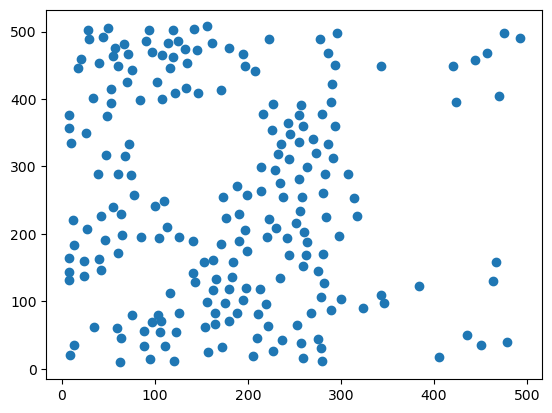

In [8]:
plt.scatter(T.X, T.Y)

In [9]:
T.sel(N=2)

<xarray.DataArray (T: 234)>
array([ 7.91648975e-01,  9.71706554e-01,  5.50518296e-01,  1.53941192e-01,
       -1.24096887e-01,  6.23860814e-02,  1.09210795e-01, -4.54256952e-02,
        3.60326370e-02,  6.44983495e-02,  3.03545800e-01,  2.45605056e-01,
        4.49957358e-01,  3.64852089e-01,  7.06188328e-01,  5.76333666e-01,
        6.40808352e-01,  5.16674965e-01,  1.38815287e-01,  3.99086604e-01,
        1.58589833e-01,  4.87269624e-01,  3.74712461e-01,  4.93590058e-01,
        6.01274795e-01,  1.01984483e+00,  8.28526968e-01,  5.49284561e-01,
        2.92580321e-01,  4.12761916e-01,  4.79716694e-01,  8.76773270e-02,
        1.27054400e-01,  2.81661655e-01,  1.96412750e-01,  4.59981306e-01,
        4.89554605e-01,  3.25069046e-01,  2.95586784e-01,  1.49471237e-01,
        6.63300597e-02,  4.09111353e-01,  4.71830685e-01,  2.94845385e-01,
        3.85648608e-01,  2.99293114e-01,  7.33553941e-02,  1.23011710e-01,
        1.84879343e-01,  1.62438013e-01,  2.99441737e-01,  1.70921050e-01,
        1.10993006e-02,  7.93796670e-03, -1.72973292e-01, -1.27882819e-01,
        4.57666160e-02,  2.09048445e-01,  3.94756891e-01,  2.62056051e-01,
       -7.96247370e-02, -1.50448283e-01, -1.88637625e-01, -1.89395324e-01,
       -3.66568808e-01, -3.91793100e-01, -3.17813117e-01, -3.82827551e-01,
       -3.24581699e-01, -4.20623106e-01, -3.96958494e-01, -3.40180324e-01,
       -2.06797491e-01, -2.31242534e-01, -1.68324758e-01, -2.17377069e-01,
        4.84237125e-02,  4.65216779e-02, -1.84204017e-01, -2.69411105e-01,
...
        1.96262687e-01,  4.21677762e-01,  5.51552895e-01,  6.36116650e-01,
        2.60400665e-01,  9.76435153e-02, -2.77386795e-01, -3.70788808e-01,
       -1.84830249e-01, -3.63180205e-01, -2.21076590e-01, -2.09166696e-01,
       -1.51546936e-01, -2.11530661e-01, -3.63588594e-01, -3.56589036e-01,
       -2.88928854e-01, -4.45027769e-01, -3.88211194e-01, -2.96288829e-01,
       -2.51531740e-01, -4.19427540e-01, -4.31201324e-01, -2.74025021e-01,
       -3.23702079e-01, -1.75334800e-01, -4.46113441e-02,  7.00757153e-02,
        3.13334292e-02,  2.76732363e-01,  4.02874299e-01,  2.08278778e-01,
        5.11898901e-02,  3.19449955e-01, -1.48951562e-01,  3.51598198e-01,
        4.90404475e-01,  4.46662296e-01,  4.42198063e-01,  5.15795590e-01,
        5.30210956e-01,  3.75182292e-01,  1.27345035e-01,  6.80817030e-02,
        6.51716108e-02, -1.71528799e-02,  1.86469443e-01,  4.34022448e-01,
        1.20679025e-01, -1.58563720e-01, -6.12187216e-02, -2.37654022e-01,
       -1.85075112e-01, -2.70507096e-01, -2.11278663e-01, -2.81650123e-01,
       -3.32233808e-01, -1.91864002e-01, -2.70332262e-01, -2.43547659e-01,
       -3.07136589e-01, -2.88469632e-01, -3.10977657e-01, -3.09047802e-01,
       -3.47018941e-01, -2.68315279e-01, -3.09681490e-01, -9.83722609e-02,
        4.47257189e-02, -1.20806514e-01, -1.75645405e-01, -1.22561556e-01,
       -2.33129971e-01, -2.01431495e-01, -1.47940238e-01, -9.57790304e-02,
       -4.79528545e-02, -2.77173271e-02])
Coordinates:
    N        int64 2
  * T        (T) int64 0 1 2 3 4 5 6 7 8 ... 225 226 227 228 229 230 231 232 233
    X        float64 152.7
    Y        float64 158.3

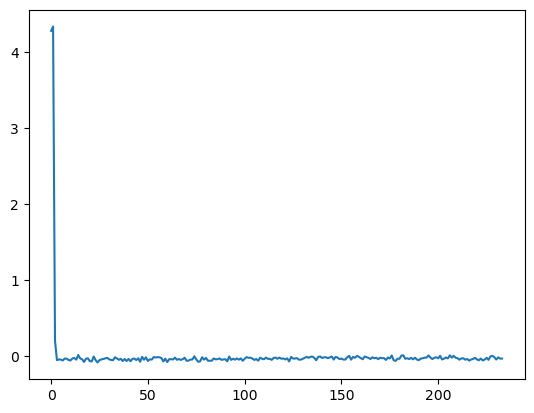

In [10]:
plt.plot(T.sel(N=8))

In [11]:
# A is output of CaImAn, Gaussian Centered around cell locations
# A binary is a binary mask that tells where cells are; A itself pretty much useless


In [12]:
zf.behavior

'/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging/behavior10to20Hz/'

## Segmenting by Behavior

In [13]:
behavior_files = os.listdir(zf.behavior)
behavior_files.sort()
behavior_files

['f11_1.mat',
 'f11_10.mat',
 'f11_11.mat',
 'f11_2.mat',
 'f11_3.mat',
 'f11_4.mat',
 'f11_5.mat',
 'f11_6.mat',
 'f11_7.mat',
 'f11_8.mat',
 'f11_9.mat',
 'f12_1.mat',
 'f12_10.mat',
 'f12_11.mat',
 'f12_2.mat',
 'f12_3.mat',
 'f12_4.mat',
 'f12_5.mat',
 'f12_6.mat',
 'f12_7.mat',
 'f12_8.mat',
 'f12_9.mat',
 'f13_1.mat',
 'f13_10.mat',
 'f13_11.mat',
 'f13_12.mat',
 'f13_13.mat',
 'f13_14.mat',
 'f13_15.mat',
 'f13_16.mat',
 'f13_17.mat',
 'f13_18.mat',
 'f13_19.mat',
 'f13_2.mat',
 'f13_20.mat',
 'f13_21.mat',
 'f13_22.mat',
 'f13_23.mat',
 'f13_24.mat',
 'f13_3.mat',
 'f13_4.mat',
 'f13_5.mat',
 'f13_6.mat',
 'f13_7.mat',
 'f13_8.mat',
 'f13_9.mat',
 'f14_1.mat',
 'f14_10.mat',
 'f14_11.mat',
 'f14_12.mat',
 'f14_13.mat',
 'f14_14.mat',
 'f14_15.mat',
 'f14_16.mat',
 'f14_17.mat',
 'f14_18.mat',
 'f14_19.mat',
 'f14_2.mat',
 'f14_20.mat',
 'f14_21.mat',
 'f14_22.mat',
 'f14_23.mat',
 'f14_24.mat',
 'f14_25.mat',
 'f14_26.mat',
 'f14_27.mat',
 'f14_28.mat',
 'f14_29.mat',
 'f14_3.m

In [14]:
def load_behavior(self, fish, idx):
    fname = os.path.join(self.behavior, f"{fish}_{idx}.mat")
    data = sio.loadmat(fname)
    

In [15]:
Bfn = os.path.join(zf.behavior, 'f1_1.mat')
print(Bfn)
B = sio.loadmat(Bfn)


/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging/behavior10to20Hz/f1_1.mat


In [16]:
B['eye_prop'].shape
B['eye_prop'][0]

array([array([[(array([[169.0155903 , 198.68477054]]), array([[-125.59894404]]), array([[242.4648225]]), array([[158.38827048]])),
               (array([[381.72109165, 329.55743897]]), array([[-102.53412332]]), array([[255.58716579]]), array([[151.83989097]]))]],
             dtype=[('Centroid', 'O'), ('Orientation', 'O'), ('MajorAxisLength', 'O'), ('MinorAxisLength', 'O')])                    ,
       array([[(array([[168.85088489, 198.85079248]]), array([[-125.73103397]]), array([[242.61439135]]), array([[158.47234233]])),
               (array([[381.80213651, 329.50439592]]), array([[-102.41136572]]), array([[254.97977302]]), array([[151.91596317]]))]],
             dtype=[('Centroid', 'O'), ('Orientation', 'O'), ('MajorAxisLength', 'O'), ('MinorAxisLength', 'O')])                    ,
       array([[(array([[168.75200442, 198.9381163 ]]), array([[-125.68050315]]), array([[242.74620593]]), array([[158.43537361]])),
               (array([[381.7610632 , 329.39898607]]), array([[-102

In [17]:
B['leye_position'].shape

(2, 3766)

In [18]:
B.keys()

dict_keys(['__header__', '__version__', '__globals__', 'leye_position', 'reye_position', 'eye_prop', 'bodyCentroid'])

In [19]:
zf.fish_names

['f1',
 'f11',
 'f12',
 'f13',
 'f14',
 'f16',
 'f3',
 'f4',
 'f6',
 'f7',
 'fCB',
 'fDB',
 'fEB',
 'fGB',
 'fHB',
 'fIB',
 'fKB',
 'fLB',
 'fVB',
 'fXB']

# Compute Simplicial Complex

In [20]:
T1 = zf.load_trajectory('f1', 2)
n, t = T1.shape

In [21]:
T2 = T1 + np.random.randn(n, t) / 2

In [22]:
(T1 - T2).max()

<xarray.DataArray ()>
array(2.03374296)

In [23]:
T1.sel(T=5)

<xarray.DataArray (N: 193)>
array([ 2.04444651e-01, -1.45561953e-01, -2.48590209e-01, -1.12763809e-01,
       -1.92404604e-01, -8.92790487e-02, -3.79439418e-01, -8.73555772e-02,
       -1.44021538e-01, -2.23098108e-01,  2.04174637e-01,  7.86665773e-01,
        3.17006184e-02, -1.86063428e-01, -6.95493815e-02,  1.96349551e-02,
        1.53344882e-01, -5.40286836e-03,  2.63477711e-02, -7.23454074e-02,
       -1.69223417e-01,  2.03523454e-02, -2.22598641e-01,  2.20578186e-01,
       -7.04960278e-02, -4.88628944e-02,  7.93967940e-02,  8.67320407e-01,
        7.32804806e-01,  1.36183280e-01, -5.58359700e-02, -1.50303466e-01,
       -4.50742548e-02, -1.89054206e-02, -1.28044495e-01,  1.58950810e-01,
       -1.11997315e-01,  2.46964369e-01, -6.68749511e-02, -1.81471754e-01,
       -3.65553835e-02, -8.37235779e-02,  5.08711451e-02,  2.23782154e-01,
       -8.88719471e-03, -1.11388381e-01, -1.68499477e-01, -3.14265001e-02,
        6.76261916e-02, -1.72417822e-01, -5.33399261e-01,  1.33976459e-01,
        1.01163437e-01, -1.48288742e-01,  7.38421683e-02, -1.25323533e-01,
        1.10083955e-02, -3.92462535e-01, -2.08735943e-01, -4.26565503e-01,
        8.91767546e-01,  4.32839206e-04,  1.54736074e-01, -2.29830958e-01,
        2.62864944e-01, -6.04277193e-02, -1.57708695e-01, -4.63125787e-02,
        2.14283399e-01, -3.87239995e-02,  1.42376229e-02, -1.06296279e-01,
       -9.76675370e-02,  5.67130965e-01, -5.97409756e-02, -2.63841929e-02,
        7.16691837e-02, -1.21631928e-01, -2.44453037e-01,  4.78888085e-01,
...
       -9.61933909e-02, -5.72986742e-02,  2.79899119e-01,  2.25529878e-01,
        4.26424595e-02, -1.64133512e-01, -4.74820142e-02,  8.82098071e-02,
        4.30079963e-01, -1.62310602e-01,  1.12822089e-01, -6.98835972e-03,
       -8.28589537e-02,  1.15106854e-02,  6.68101374e-02,  1.72967981e-02,
        2.46160103e-02, -7.47266499e-02, -2.07243108e-01, -9.41695298e-02,
       -1.61173201e-01, -8.70082957e-02,  5.01895088e-02,  3.51659281e-02,
       -1.07960660e-01,  3.88728892e-01, -2.24250698e-02,  2.30561870e-02,
        1.08467154e-01, -7.18309897e-02, -1.67021190e-02,  4.67249097e-02,
       -1.67775965e-01, -1.44012144e-01,  2.24177067e-01, -1.09456501e-01,
        2.16253479e-01, -1.42481261e-01, -1.90005831e-01, -6.21185884e-02,
        1.62130339e-02,  1.02591868e-01,  2.56827830e-02,  5.51885487e-02,
       -2.27683520e-01, -3.71661896e-02,  1.39893546e-02, -7.05916059e-03,
       -2.37627939e-02, -1.16714270e-01,  2.65546997e-02,  3.99571229e-01,
        9.09509215e-03, -9.57948093e-02,  3.31087593e-02,  1.46098819e-01,
       -8.85892754e-02,  1.26911587e-01,  4.00383598e-03,  7.62962252e-03,
       -8.45713469e-02,  1.05138550e-02, -1.60825908e-01,  1.00109419e-01,
        1.34229476e-01,  7.45026311e-02,  4.21463038e-02, -2.81474489e-02,
        5.54305259e-02,  1.11064180e-01,  1.51318812e-01, -1.14660520e-01,
        1.95301200e-01, -1.54186162e-01, -2.06970064e-01, -1.25496413e-01,
        9.55098971e-02])
Coordinates:
  * N        (N) int64 1 2 3 4 5 6 7 8 9 ... 185 186 187 188 189 190 191 192 193
    T        int64 5
    X        (N) float64 108.0 138.3 136.6 88.54 ... 167.5 421.2 320.6 193.8
    Y        (N) float64 364.9 502.4 474.7 361.2 ... 245.1 40.83 142.8 305.6

In [27]:
class SimplicialComplex:
    def __init__(self, trajectories):
        """
        Input: 
            trajectories is a list of neural time series of N dimensional vectors (Nxti) matrix). Each time series is xarray data array
            Time Series assumed to lie on k<N dimensional manifold
            Time series length does not have to be the same, N has to be same for trajectories to exist in same space
            I matrices of size N by Ti 
        """
        self.N = trajectories[0].shape[0]
        self.trajectories = trajectories
        self.vertices = []
        self.edges = []
        for t in trajectories:
            self.add_trajectory(t)

    def add_trajectory(self, trajectory):
        N, T = trajectory.shape
        assert N == self.N, "trajectory dimensionality does not match" 
        times = trajectory['T']
        for t in range(T):
            v = trajectory.sel(T=times[t]).data
            self.vertices.append(v)
            if(t+1 < T):
                v_next = trajectory.sel(T=times[t+1]).data
                self.edges.append((v, v_next))

    def connect_edges(self, epsilon, add=True):
        vertices = np.array(self.vertices)
        new_edges = []
        self.vertices = vertices
        V, D = vertices.shape
        pairwise_diff = vertices[:, np.newaxis, :] - vertices[np.newaxis, :, :]
        self.pairwise_distances = np.linalg.norm(pairwise_diff, axis=2)
        np.fill_diagonal(pairwise_distances, np.inf)
        row_indices, col_indices = np.where(pairwise_distances < epsilon)
        for i, j in zip(row_indices, col_indices):
            new_edges.append((vertices[i], vertices[j]))
        if(add):
            self.edges = self.edges + new_edges
            
    def boundary_matrix(self):
        pass

In [28]:
X = SimplicialComplex([T1, T2])
print(f"Initially, {len(X.edges)} edges")

Initially, 466 edges


In [169]:
X.connect_edges(epsilon=3)
print(len(X.edges))

11726


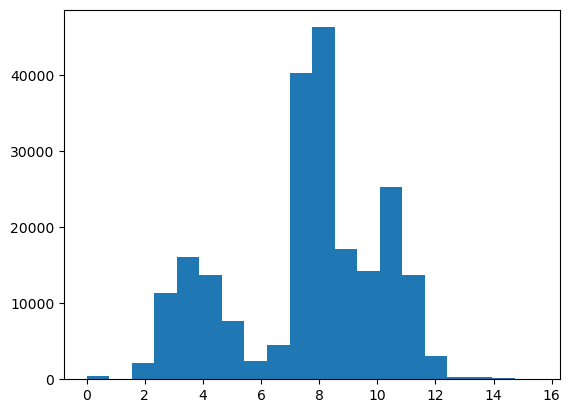

In [104]:
dists = X.pairwise_distances.flatten()
counts, bins, bar = plt.hist(dists, bins=20)
plt.show()

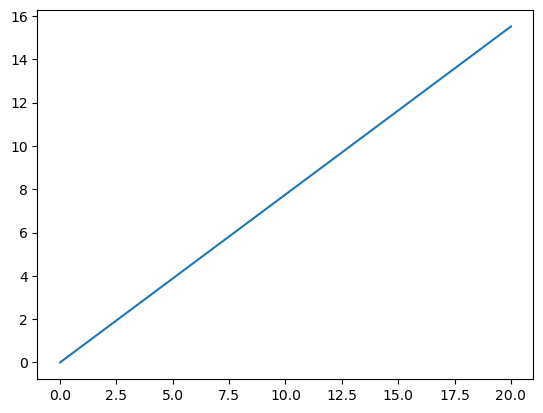

In [109]:
plt.plot(np.arange(len(bins)), bins)